In [1]:
import os
import sys

from random import shuffle

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn

from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader
from torch.autograd import Variable
from torch.nn import init
from scipy.misc import imread, imresize


BATCH_SIZE = 64
EPOCHS = 1
IMAGE_SIZE = 128
DTYPE = torch.cuda.FloatTensor

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
def preprocess_img(path, height=IMAGE_SIZE, width=IMAGE_SIZE):
    img = imread(path)
    img = imresize(img, (height, width, 3)).astype(np.float32)
    img /= 255.0
    return img.transpose(2, 1, 0)


def preprocess_imgs(paths, batch_size, height=IMAGE_SIZE, width=IMAGE_SIZE):
    imgs = np.zeros((batch_size, height, width, 3))
    ages = np.zeros((batch_size, 1))
    idx = 0
    skip = 0
    for path in paths:
        img = preprocess_img(path, height, width)
        if img is None:
            skip += 1
            continue
        imgs[idx, :, :, :] = img
        ages[idx] = get_age(path)
        idx += 1
        if idx == batch_size:
            break
    imgs = imgs.transpose(0, 3, 2, 1)
    return imgs, ages, skip


def get_age(path):
    *rest, dob, taken = path[path.rfind('/')+1:-4].split('_')
    birth = dob[:4]
    age = float(int(taken) - int(birth))
    return np.array([age])


def initialize_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.xavier_uniform(m.weight.data)

In [3]:
class IMDB(Dataset):
    def __init__(self, train=True, train_size=0.8):
        file_paths = []
        for root, dirs, files in os.walk('/datasets/IMDB_faces/imdb_crop'):
            for file in files:
                if not file.endswith('.jpg'):
                    continue
                path = os.path.join(root, file)
                file_paths.append(path)
        files_cnt = len(file_paths)
        if train:
            self.file_paths = file_paths[:int(train_size*files_cnt)]
        else:
            self.file_paths = file_paths[int(train_size*files_cnt):]
        self.files_cnt = len(self.file_paths)
        print('Found %d images' % self.files_cnt)
        
        
    def __getitem__(self, index):
        path = self.file_paths[index]
        return torch.Tensor(preprocess_img(path)), torch.Tensor(get_age(path))
    
    def __len__(self):
        return self.files_cnt

    
imdb_train_dataset = IMDB()
imdb_test_dataset = IMDB(train=False)

loader_train = DataLoader(imdb_train_dataset, batch_size=BATCH_SIZE, shuffle=True)
loader_test = iter(DataLoader(imdb_test_dataset, batch_size=BATCH_SIZE//2, shuffle=True))

Found 350457 images
Found 87615 images


In [4]:
class Flatten(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        N, C, H, W = x.size()
        x = x.view(N, C * H * W)
        return x


class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.main = nn.Sequential(
            nn.Conv2d(3, 32, 3, stride=1, padding=1),  # N x 32 x 128 x 128
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2, stride=2),  # N x 32 x 64 x 64
            nn.Conv2d(32, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, stride=2),  # N x 64 x 32 x 32
            nn.Conv2d(64, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.Conv2d(128, 128, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, stride=2),  # N x 128 x 16 x 16
            nn.Conv2d(128, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.Conv2d(256, 256, 3, stride=1, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(2, stride=2),  # N x 256 x 8 x 8
            Flatten(),
            nn.Linear(8*8*256, 2048),
            nn.BatchNorm1d(2048),
            nn.Linear(2048, 1024),
            nn.BatchNorm1d(1024),
            nn.Linear(1024, 1)
        )
        
    def forward(self, x):
        x = self.main(x)
        return x

Epoch 1
Iter:  400 Loss:  8.631 Test-Loss: 11.198
Predict Age: 35.8  Real Age: 42.0


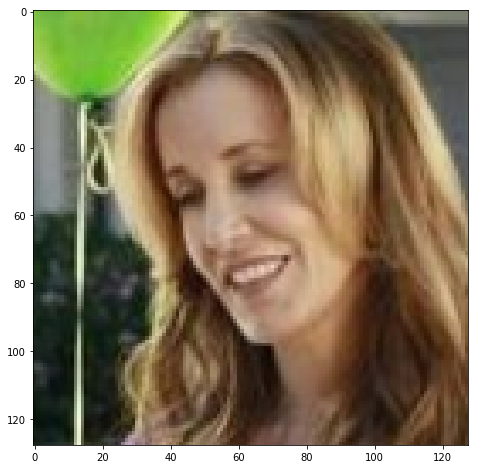

Iter:  800 Loss: 11.971 Test-Loss: 11.288
Predict Age: 35.9  Real Age: 52.0


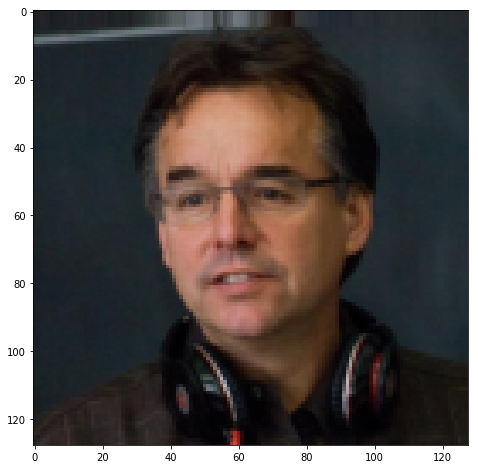

Iter: 1200 Loss:  9.190 Test-Loss:  7.375
Predict Age: 36.1  Real Age: 42.0


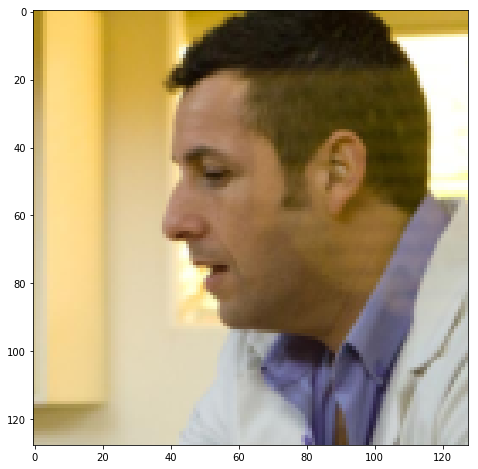

Iter: 1600 Loss:  8.436 Test-Loss:  9.053
Predict Age: 32.6  Real Age: 42.0


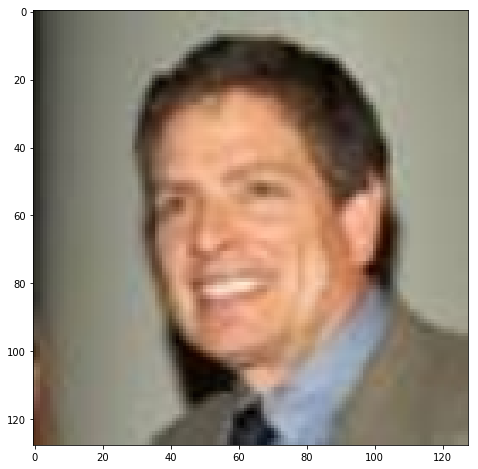

Iter: 2000 Loss:  8.613 Test-Loss:  9.414
Predict Age: 39.0  Real Age: 54.0


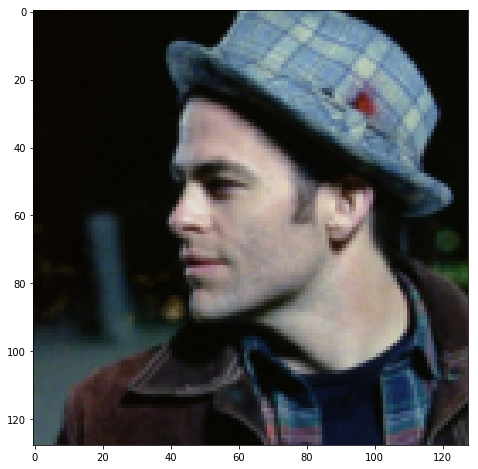

Iter: 2400 Loss: 10.980 Test-Loss: 11.526
Predict Age: 51.4  Real Age: 45.0


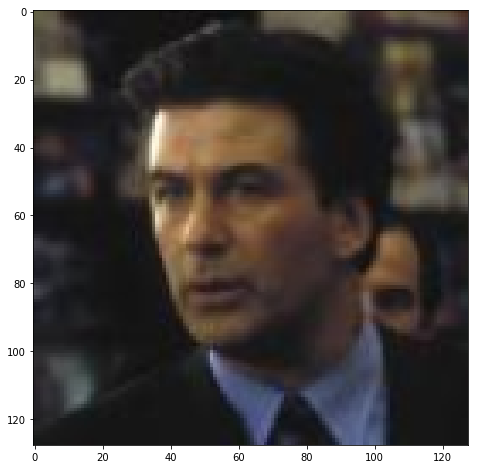

Iter: 2800 Loss:  9.086 Test-Loss: 10.166
Predict Age: 36.7  Real Age: 38.0


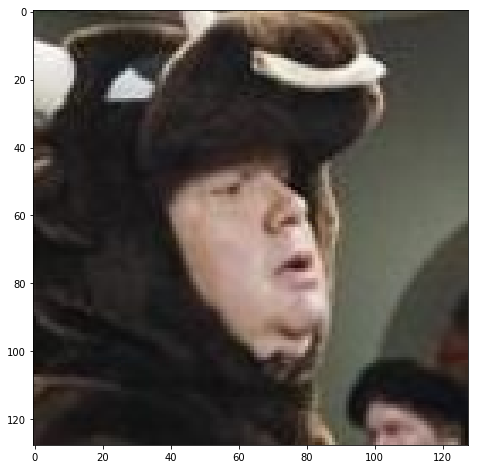

Iter: 3200 Loss:  8.318 Test-Loss:  8.967
Predict Age: 37.1  Real Age: 21.0


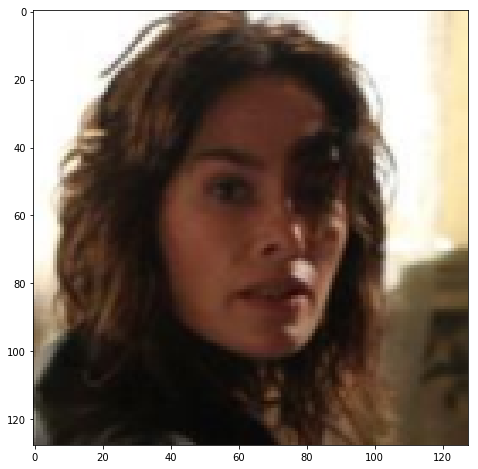

Iter: 3600 Loss: 10.301 Test-Loss: 13.772
Predict Age: 33.7  Real Age: 31.0


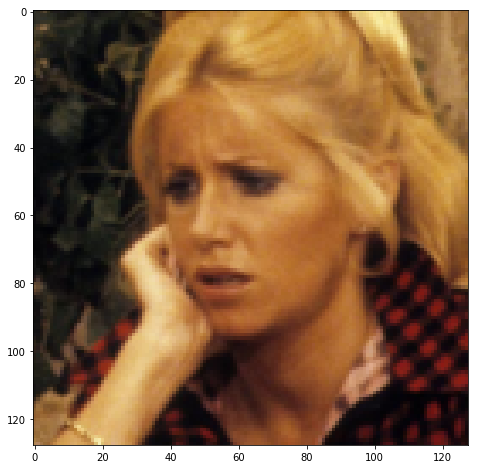

Iter: 4000 Loss:  9.439 Test-Loss:  9.870
Predict Age: 39.4  Real Age: 27.0


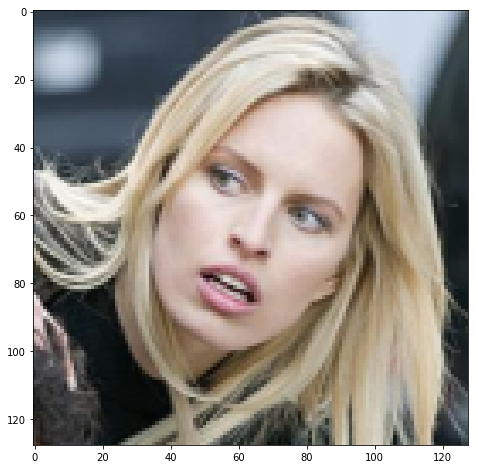

Iter: 4400 Loss:  8.066 Test-Loss: 10.434
Predict Age: 41.5  Real Age: 32.0


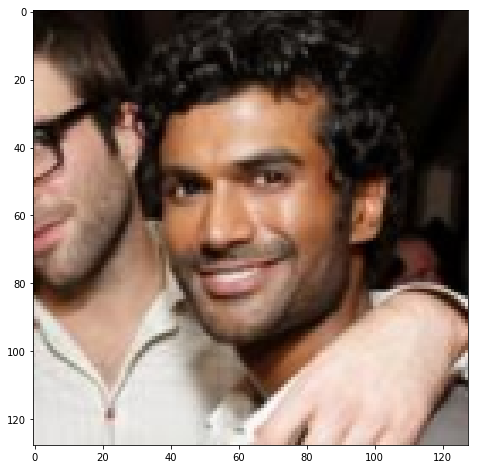

Iter: 4800 Loss:  8.790 Test-Loss: 12.684
Predict Age: 38.8  Real Age: 23.0


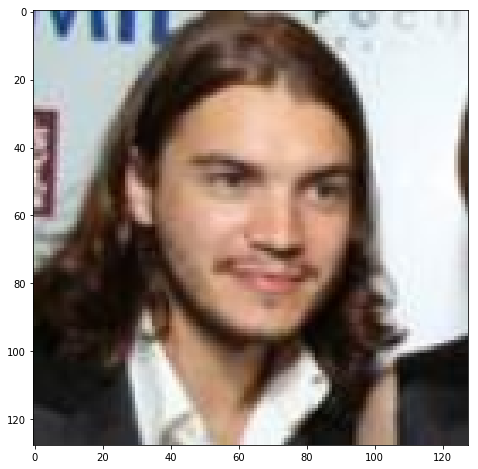

KeyboardInterrupt: 

In [5]:
model = CNN().type(DTYPE)
model.apply(initialize_weights)
loss_fn = nn.L1Loss()
optimizer = optim.Adam(model.parameters())

train_loss_history = []
test_loss_history = []
plt.figure()
for epoch in range(1, 1 + EPOCHS):
    print('Epoch', epoch)
    iters = 0
    for imgs, age in loader_train:
        imgs, age = Variable(imgs).type(DTYPE), Variable(age).type(DTYPE)
        h = model(imgs)
        loss = loss_fn(h, age)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        iters += 1
        loss = loss.cpu().data[0]
        train_loss_history.append(loss)
        if iters % 400 == 0:
            test_imgs, test_ages = next(loader_test)
            test_imgs, test_ages = Variable(test_imgs).type(DTYPE), Variable(test_ages).type(DTYPE)
            h = model(test_imgs)
            test_loss = loss_fn(h, test_ages)
            test_loss = test_loss.cpu().data[0]
            test_loss_history.append(test_loss)
            
            print('Iter: %4d Loss: %6.3f Test-Loss: %6.3f' % (iters, loss, test_loss))
            img = imgs.cpu().data[0].numpy().transpose(2, 1, 0)
            hage = h.cpu().data[0].numpy()[0]
            rage = age.cpu().data[0].numpy()[0]
            print('Predict Age: %.1f  Real Age: %.1f' % (hage, rage))
            plt.imshow(img)
            plt.show()
        else:
            sys.stdout.flush()
            sys.stdout.write('Iter: %4d Loss: %6.2f\r' % (iters, loss))